In [1]:
import sys  
sys.path.insert(1, './../../../ESN-IP/IP/.')

import random

random.seed(10)

from DATA import VerstraetenDambre

data = VerstraetenDambre()
data.delay_timeseries(1)
data.split([80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()


In [2]:
import matplotlib.pyplot as plt

In [3]:
data.X_TS.shape

torch.Size([1000])

In [4]:
len(data.Y_TR)

4000

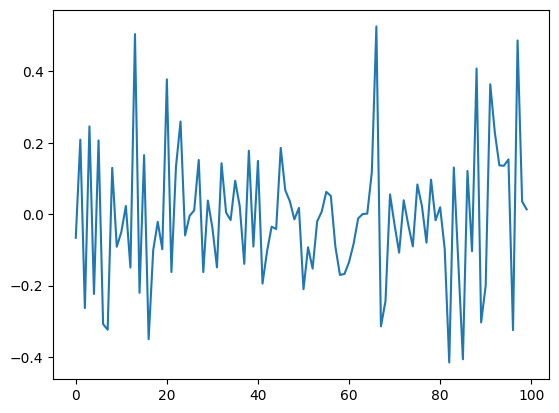

In [11]:
data.X_FULL.shape

plt.plot(data.Y_TS.numpy()[0:100])

In [7]:
data.Y_TS.shape

torch.Size([1000])

In [3]:
from Metrics import MSE
from IPReservoir import IPReservoir
from ESN import Reservoir, EchoStateNetwork
from IntrinsicPlasticity import IPMask, IPDistribution

N_UNITS_LIST = [100, 150, 200, 250]
W_range=(-0.5, 0.5)
initial_rho = 0.5
desired_rhos = [0.95, 0.95, 0.95, 0.95]
bias_range = [-0.1, 0.1]

In [4]:
REPETITIONS = 5
max_epochs = 15 
columns = ["Name", "TYPE", "MSE", "MC", "Lambda max", "delta_phI", "KL", "Rho", "A-Norm", "B-Norm"]
models_num = len(N_UNITS_LIST)*len(desired_rhos)
rows = []

for N_UNITS, desired_rho in zip(N_UNITS_LIST, desired_rhos):
    config_string = f"{N_UNITS} UNIT - Spectral Radius: {desired_rho}"
    names = ["Vanilla", "Gauss 1", "Gauss 2", "Bimodal", "Trim 1", "Trim 2"]
    identifiers = [ f"- {name} - {config_string} " for name in names]
    
    for R in range(REPETITIONS):
        vanilla_reservoir = Reservoir(N = N_UNITS, desired_rho = desired_rho, W_range=W_range, bias_range=bias_range)
        
        gaussian_reservoir_1 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.5, apply_activation=True))
        gaussian_reservoir_2 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.25, apply_activation=True))

        bimodal_reservoir = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.mixedBimodalMask(N_UNITS, 0.69, 0.725, apply_activation=True))
        
        trimodal_reservoir_1 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.15, 0.92, apply_activation=True))
        trimodal_reservoir_2 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.075, 0.725, apply_activation=False))
        
        print("Traning IP models")
        gaussian_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=True)
        gaussian_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=False)
        bimodal_reservoir.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=False)
        trimodal_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000005, verbose=False)
        trimodal_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)

        models = [vanilla_reservoir, gaussian_reservoir_1, gaussian_reservoir_2, bimodal_reservoir, trimodal_reservoir_1, trimodal_reservoir_2]

        for model_index in range(len(models)): 
            model = models[model_index]

            esn = EchoStateNetwork(model)
            esn.train(X_TR,Y_TR, 0)

            mse = esn.evaluate(X_TS, Y_TS, metric=MSE()).item()
            
            mc = esn.MemoryCapacity().item()
            
            lambda_max = model.LCE(X_TS)

            de_phi = model.de_fi()

            KL = model.kl_value.item() if model_index != 0 else None
            a_norm = model.a.norm().item() if model_index != 0 else 1
            b_norm = model.b.norm().item() if model_index != 0 else 0

            # columns = ["________________Name____________________","TYPE", "MSE","MC","Lambda max","delta_phI","KL", "Rho", "A-Norm", "B-Norm"]
            rows.append([f"{R+1}) {identifiers[model_index]}" , model_index, mse, mc, lambda_max, de_phi, KL, model.rho().item(), a_norm, b_norm])
            print(rows[-1])

        
        


Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10542824119329453. | Spectral radius: 0.5505279898643494
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11985553801059723. | Spectral radius: 0.5995883345603943
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.15152747929096222. | Spectral radius: 0.6570245623588562
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.20835261046886444. | Spectral radius: 0.7513827681541443
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.27538400888442993. | Spectral radius: 1.219495177268982
Too high spectral radius: 1.219495177268982, rolling back to previous state!
- Epoch: 1) | KL Divergence value: 0.1923423409461975. | Spectral radius: 0.7213338613510132
Epoch: 5) - Safe mode traning - Learning Rate = 6.25e-06
- Epoc

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.24403e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.38778e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.4054e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 0.04895595461130142, 9.832283973693848, -0.25231302, 0.5727623480848306, 0.24198941886425018, 0.9468087553977966, 16.533349990844727, 4.041267395019531]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.20428e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.28018e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.26482e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 0.049333471804857254, 7.978605270385742, -0.17517057, 0.3391404683016656, 0.21278993785381317, 0.9492055177688599, 15.661885261535645, 5.582941055297852]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.89911e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.95854e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.95712e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 0.04916859045624733, 8.578271865844727, -0.46470737, 0.13239076041636924, 0.09768207371234894, 0.9486441612243652, 18.694955825805664, 9.49831485748291]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 0.04896540567278862, 9.588642120361328, -0.083889976, 0.3436421234907522, 0.07198900729417801, 0.9422455430030823, 22.297527313232422, 9.53109073638916]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 0.0497550368309021, 9.559992790222168, -0.11199249, 0.1309770147074552, 0.0643717348575592, 0.9409663677215576, 17.882747650146484, 8.286479949951172]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1039842963218689. | Spectral radius: 0.5509920716285706
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11414074897766113

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.05049e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.6681e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.6643e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['2) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 0.049113355576992035, 9.45686149597168, -0.10790006, 0.17015588932101788, 0.27227476239204407, 0.9443986415863037, 19.754812240600586, 5.817588806152344]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.87163e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.09459e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.08412e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 0.04919595271348953, 9.214600563049316, -0.2203836, 0.06229752238110984, 0.1885809451341629, 0.9213070273399353, 15.483321189880371, 5.4706244468688965]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.12545e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.20172e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.1918e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['2) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 0.04948967322707176, 8.11451244354248, -0.89630604, 0.06876193695654224, 0.09562409669160843, 0.9471642971038818, 18.64228630065918, 8.989216804504395]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 0.04889529198408127, 9.452104568481445, -0.3277993, 0.14177717473503232, 0.07648806273937225, 0.9452721476554871, 18.804906845092773, 7.899328708648682]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 0.04857894778251648, 9.980877876281738, -0.22867754, 0.0527092814918973, 0.05966591462492943, 0.9466412663459778, 17.09868621826172, 8.13810920715332]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1020154058933258. | Spectral radius: 0.5507730841636658
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11218303442001343.

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.77841e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.12473e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.21135e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 0.048631977289915085, 9.511799812316895, -0.065735504, 0.5322593705655363, 0.261095255613327, 0.9447250366210938, 18.43583869934082, 5.176058769226074]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.85119e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.84362e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.7516e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 0.04978041723370552, 8.31446647644043, -0.12288253, 0.047021881929211966, 0.24095690250396729, 0.9422447085380554, 18.50266456604004, 7.339707374572754]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.42655e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.4158e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.31939e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 0.049188192933797836, 7.711653709411621, -0.3696311, 0.05548010820325632, 0.10083988308906555, 0.949404776096344, 18.19230842590332, 8.95167350769043]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.055e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.77215e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.5392e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local

['3) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 0.050056178122758865, 9.6552095413208, -0.16221644, 0.08355216673929343, 0.07469204813241959, 0.9379357099533081, 18.838764190673828, 8.44059944152832]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.86487e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.95164e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.3207e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 0.04830789193511009, 9.130914688110352, -0.06422505, 0.08297371290861669, 0.061282284557819366, 0.9485525488853455, 17.74201774597168, 7.635814189910889]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10402398556470871. | Spectral radius: 0.5501363277435303
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11433877050876617. | Spectral radius: 0.5980700254440308
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.13619564473628998. | Spectral radius: 0.6460965871810913
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.18428029119968414. | Spectral radius: 0.6992713212966919
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.2589415907859802. | Spectral radius: 0.8488731980323792
Epoch: 5) - Safe mode tr

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.37175e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12949e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.12232e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 0.04899495095014572, 9.67284107208252, -4.3705006, 0.05893876475150134, 0.2821880877017975, 0.9492635726928711, 18.53695297241211, 5.113144874572754]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.18948e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.13172e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.1053e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 0.048519931733608246, 8.855647087097168, -0.07449556, 0.05057609073849054, 0.19460062682628632, 0.9479213953018188, 18.55735206604004, 7.144015789031982]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.72443e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.71211e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.70201e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 0.04915841668844223, 8.01466178894043, -1.4617707, 0.06007507069868523, 0.10270871222019196, 0.9483343362808228, 19.064247131347656, 9.777292251586914]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.15892e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.8315e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.0161e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['4) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 0.04953087866306305, 9.739468574523926, -0.24776074, 0.19536085463800107, 0.08821602165699005, 0.9469848871231079, 20.1898136138916, 9.109902381896973]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3405e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.24788e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.34213e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 0.04867227002978325, 9.743646621704102, -0.12588239, 0.044959721093508834, 0.057834453880786896, 0.9486215710639954, 18.12665557861328, 8.564141273498535]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10036163032054901. | Spectral radius: 0.5504830479621887
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10845664888620377. | Spectral radius: 0.5991575121879578
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.12473209947347641. | Spectral radius: 0.6494542360305786
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1584099978208542. | Spectral radius: 0.7114992737770081
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.21049192547798157. | Spectral radius: 0.8153475522994995
Epoch: 5) - Safe mode t

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.10008e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.72098e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.72944e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 0.04841990023851395, 9.385534286499023, -1.5762544, 0.06718073016043904, 0.23582252860069275, 0.9358599781990051, 17.892925262451172, 4.605672836303711]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.67479e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.82527e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.04335e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 0.0493633970618248, 9.452655792236328, -0.43562126, 0.07344141698495689, 0.1965768188238144, 0.9055833220481873, 14.517831802368164, 5.072729587554932]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.35863e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.73913e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.75717e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 0.048555150628089905, 8.126608848571777, -1.3414819, 0.05148987085432283, 0.10277385264635086, 0.9468008875846863, 18.604520797729492, 9.566306114196777]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.47847e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.82599e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.61067e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 0.04885902628302574, 9.190786361694336, -0.115971446, 0.06897707020806153, 0.07418765872716904, 0.9359217882156372, 18.06922721862793, 7.771904945373535]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 0.04831046983599663, 9.59231948852539, -0.11616564, 0.04444183620915975, 0.05869990959763527, 0.943578839302063, 17.482088088989258, 7.878304481506348]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10408008843660355. | Spectral radius: 0.5513758659362793
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1161460429430008. | Spectral radius: 0.6024259924888611
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.14204949140548706. | Spectral radius: 0.6607612371444702
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1)

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52124e-14): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.78561e-15): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.89641e-15): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 0.04935291409492493, 9.728008270263672, -0.63647693, 0.6285266529271594, 0.2763284742832184, 0.9486592411994934, 22.921432495117188, 6.217596530914307]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 0.04914635419845581, 9.503960609436035, -0.28014237, 0.05662597953054199, 0.2244948148727417, 0.9483555555343628, 20.617652893066406, 7.848790168762207]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.84833e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.34937e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.48642e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 0.05067723989486694, 8.978328704833984, -0.60324866, 0.06449729473256505, 0.1125485748052597, 0.9498583674430847, 23.477678298950195, 11.43504810333252]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 0.049503155052661896, 10.830357551574707, -0.103004806, 0.04719769504178456, 0.08276854455471039, 0.9469733238220215, 19.53618621826172, 9.045034408569336]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 0.050109196454286575, 11.02087688446045, -0.0997492, 0.17918855296223174, 0.0565015971660614, 0.946993887424469, 27.159461975097656, 11.665647506713867]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10188387334346771. | Spectral radius: 0.549187421798706
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.112039014697

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.97557e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.5521e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.52872e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['2) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 0.049051202833652496, 10.427882194519043, -0.14519902, 0.061264363864615465, 0.25139138102531433, 0.9470324516296387, 22.02147674560547, 5.940290451049805]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 0.0498662069439888, 8.875454902648926, -0.18451868, 0.24227014755112342, 0.23783248662948608, 0.9452273845672607, 22.76041030883789, 9.02612590789795]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.19963e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.13318e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.1332e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['2) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 0.049476005136966705, 8.762408256530762, -1.0886116, 0.09265981998345836, 0.10974760353565216, 0.94981449842453, 24.208894729614258, 13.006799697875977]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 0.04909293353557587, 10.552318572998047, -0.16317955, 0.16094383402489043, 0.0731377825140953, 0.9355913996696472, 21.22148323059082, 8.87014102935791]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 0.050622571259737015, 10.416580200195312, -0.09151845, 0.05187608116060403, 0.05762123689055443, 0.9345008730888367, 25.733394622802734, 11.039586067199707]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.104024238884449. | Spectral radius: 0.551055908203125
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11554253101348

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.86472e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.18466e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.11746e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 0.05157003924250603, 10.877882957458496, -0.9113188, 0.05164846684977038, 0.24464580416679382, 0.9167842864990234, 21.123327255249023, 5.495420455932617]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 0.04961394518613815, 9.769855499267578, -0.137152, 0.05633097044631676, 0.20821203291416168, 0.9498482942581177, 21.520782470703125, 8.233636856079102]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.67688e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.609e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.64083e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['3) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 0.05043545365333557, 9.119810104370117, -0.4855656, 0.10064248105267697, 0.10694334656000137, 0.9495339393615723, 23.17229461669922, 11.55332088470459]
Reservoir warmed up with the first 100 time steps
['3) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 0.051076196134090424, 9.907432556152344, -0.10875931, 0.06919182885224334, 0.07433133572340012, 0.9461297392845154, 23.412979125976562, 11.01174259185791]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 0.05015188455581665, 10.708606719970703, -0.17689551, 0.6100284501856563, 0.06762098520994186, 0.943191647529602, 24.61658477783203, 10.200860977172852]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10368356108665466. | Spectral radius: 0.551175594329834
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11297564953565

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.59356e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.40119e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.30691e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 0.05057395622134209, 10.599027633666992, -0.4470872, 0.3086085205189638, 0.24551473557949066, 0.9411457180976868, 22.225025177001953, 5.856394290924072]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 0.04973597079515457, 9.810125350952148, -0.3563818, 0.26252477650118705, 0.21717999875545502, 0.9195313453674316, 20.034469604492188, 7.479525089263916]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.6711e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.46732e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.63499e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 0.049972426146268845, 8.176128387451172, -0.23789315, 0.0436622609749328, 0.09699317812919617, 0.9485788345336914, 23.835102081298828, 12.164873123168945]
Reservoir warmed up with the first 100 time steps


In [14]:
import pandas as pd 
df = pd.DataFrame(rows)
df.to_csv("./7_RESULTS_VerstraetenDambre.csv", header=columns)

In [15]:
df = pd.DataFrame(rows, columns=columns)

In [2]:
import pandas as pd 

In [4]:
df = pd.read_csv("./RESULTS/7_RESULTS_VerstraetenDambre.csv")

In [5]:
df

,Unnamed: 0,Name,TYPE,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
0,0,1) - Vanilla - 100 UNIT - Spectral Radius: 0.95,0,0.047673,18.497938,-0.103597,0.053663,NaN,0.950000,1.000000,0.000000
1,1,1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95,1,0.049179,8.462865,-1.785476,0.082104,0.285972,0.948949,17.470072,4.659165
2,2,1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95,2,0.048813,8.139781,-3.275302,0.621249,0.220244,0.945875,18.300255,7.182390
3,3,1) - Bimodal - 100 UNIT - Spectral Radius: 0.95,3,0.049077,8.181185,-1.925430,0.321009,0.108781,0.949612,19.047150,9.461167
4,4,1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95,4,0.049190,9.478030,-0.119054,0.060177,0.078437,0.944941,18.479555,7.982610
5,5,1) - Trim 2 - 100 UNIT - Spectral Radius: 0.95,5,0.048915,9.695772,-0.077944,0.068226,0.058297,0.945729,18.460842,8.143819
6,6,1) - Vanilla - 150 UNIT - Spectral Radius: 0.95,0,0.049314,19.442188,-0.149194,0.100916,NaN,0.950001,1.000000,0.000000
7,7,1) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95,1,0.049504,10.814193,-1.847376,0.101629,0.248814,0.939240,20.335196,5.024570
8,8,1) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95,2,0.049803,9.197133,-0.677141,0.045289,0.242102,0.949601,22.218372,8.530670
9,9,1) - Bimodal - 150 UNIT - Spectral Radius: 0.95,3,0.050572,8.655501,-0.708231,0.108545,0.099431,0.948363,23.385010,11.580247


: 

In [16]:
df.groupby("TYPE").mean()

,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
TYPE,,,,,,,,
0,0.049654,21.440380,-0.125018,0.064085,NaN,0.950001,1.000000,0.000000
1,0.049899,10.527854,-1.236218,0.072963,0.253518,0.945428,22.094965,5.502923
2,0.050967,9.354740,-1.072411,0.225304,0.232652,0.947583,22.879853,8.824532
3,0.061190,8.971714,-1.079283,0.137612,0.105143,0.948918,24.950018,12.368864
4,0.050490,10.286899,-0.125280,0.072714,0.085273,0.947212,23.699061,10.701966
5,0.049840,10.992300,-0.095089,0.149068,0.059411,0.946076,23.001382,10.178203
